<a href="https://colab.research.google.com/github/mohsenperfection/ML/blob/CHW03/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 99102083
Name = 'Mohsen'
Last_Name = 'Kamalabadi Farahani'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

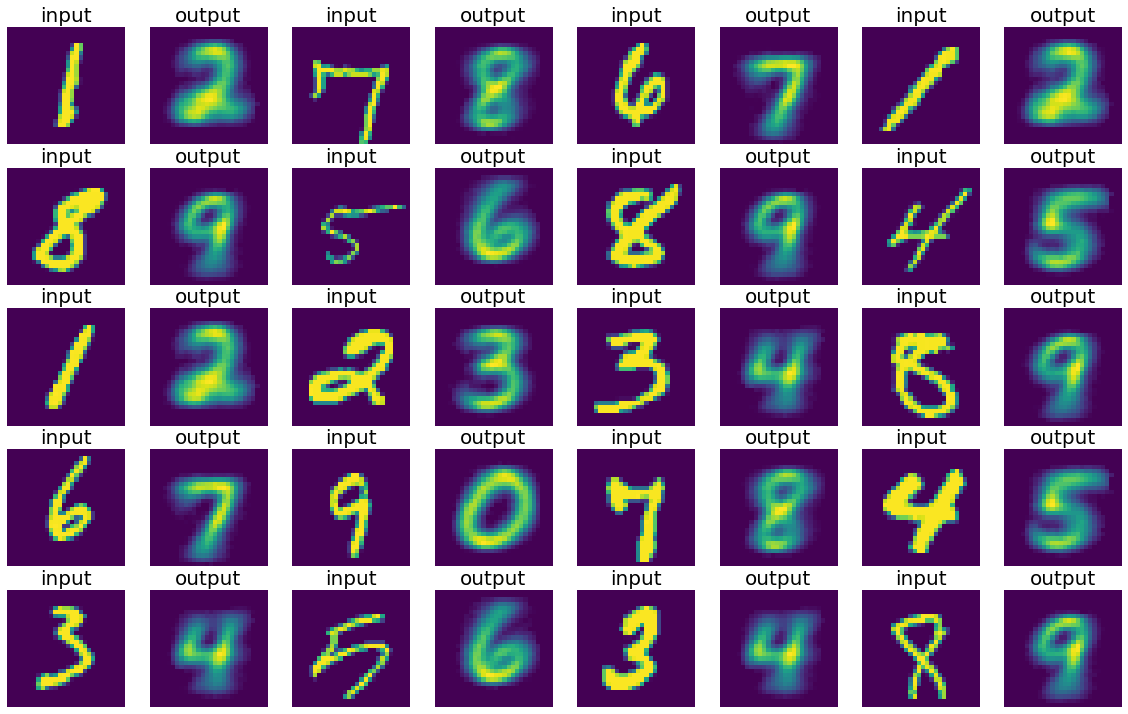

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [ ]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [ ]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [ ]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [ ]:
# place for your custom functions for training and evaluation of the autoencoder
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0.0

    for X_batch, Y_batch, _ in dataloader:
        X_batch = X_batch.view(X_batch.size(0), -1).to(device).float()
        Y_batch = Y_batch.view(Y_batch.size(0), -1).to(device).float()

        optimizer.zero_grad()
        output = model(X_batch)
        loss = F.mse_loss(output, Y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)

    return epoch_loss / len(dataloader.dataset)

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for X_batch, Y_batch, _ in dataloader:
            X_batch = X_batch.view(X_batch.size(0), -1).to(device).float()
            Y_batch = Y_batch.view(Y_batch.size(0), -1).to(device).float()

            output = model(X_batch)
            loss = F.mse_loss(output, Y_batch)

            epoch_loss += loss.item() * X_batch.size(0)

    return epoch_loss / len(dataloader.dataset)



## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [ ]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####

ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [ ]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
# Training and validation loop
num_epochs = 20
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()

torch.save(best_model_state, 'best_autoencoder_model.pth')
print("Training complete. Best model saved.")


Epoch 1/20, Train Loss: 0.0932, Validation Loss: 0.0678
Epoch 2/20, Train Loss: 0.0674, Validation Loss: 0.0670
Epoch 3/20, Train Loss: 0.0663, Validation Loss: 0.0658
Epoch 4/20, Train Loss: 0.0646, Validation Loss: 0.0631
Epoch 5/20, Train Loss: 0.0616, Validation Loss: 0.0605
Epoch 6/20, Train Loss: 0.0592, Validation Loss: 0.0587
Epoch 7/20, Train Loss: 0.0581, Validation Loss: 0.0576
Epoch 8/20, Train Loss: 0.0571, Validation Loss: 0.0570
Epoch 9/20, Train Loss: 0.0565, Validation Loss: 0.0564
Epoch 10/20, Train Loss: 0.0561, Validation Loss: 0.0561
Epoch 11/20, Train Loss: 0.0558, Validation Loss: 0.0559
Epoch 12/20, Train Loss: 0.0556, Validation Loss: 0.0557
Epoch 13/20, Train Loss: 0.0554, Validation Loss: 0.0556
Epoch 14/20, Train Loss: 0.0553, Validation Loss: 0.0555
Epoch 15/20, Train Loss: 0.0552, Validation Loss: 0.0554
Epoch 16/20, Train Loss: 0.0550, Validation Loss: 0.0553
Epoch 17/20, Train Loss: 0.0549, Validation Loss: 0.0552
Epoch 18/20, Train Loss: 0.0549, Validat

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [ ]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
best_model_path = 'best_autoencoder_model.pth'
ae.load_state_dict(torch.load(best_model_path, map_location=device))
print("Best model loaded.")

Best model loaded.


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

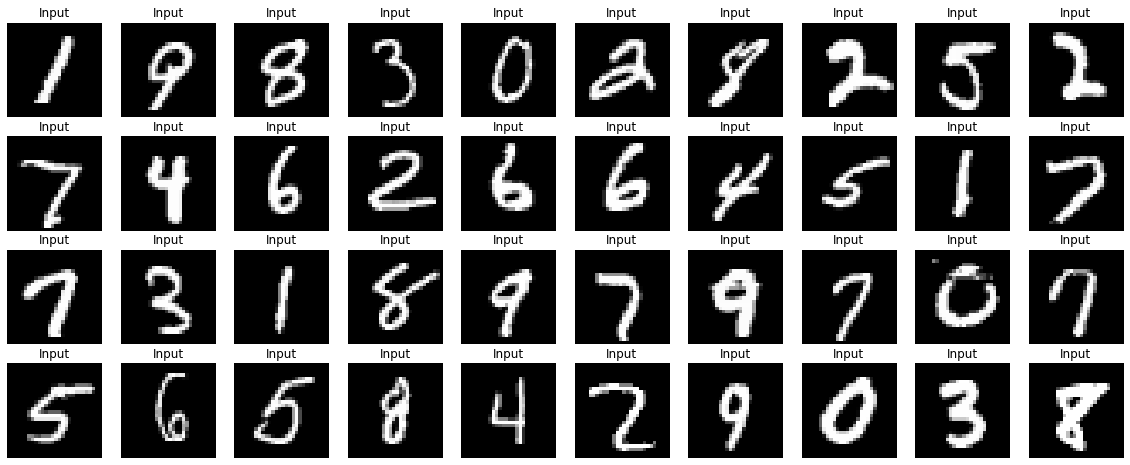

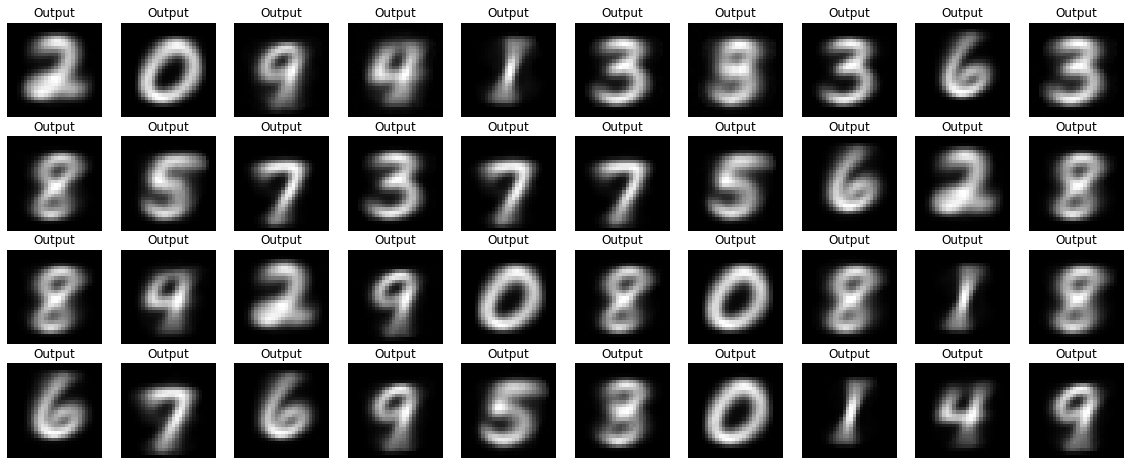

In [ ]:
#### VISUALIZE YOUR MODEL ####
import matplotlib.pyplot as plt

test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=40,
    shuffle=False
)

def visualize_model(model: nn.Module, dataloader: DataLoader):
    model.eval()
    inputs, outputs = [], []

    with torch.no_grad():
        for X_batch, Y_batch, _ in dataloader:
            X_batch = X_batch.view(X_batch.size(0), -1).to(device).float()
            Y_batch = Y_batch.view(Y_batch.size(0), -1).to(device).float()

            output = model(X_batch)
            inputs.append(X_batch.cpu())
            outputs.append(output.cpu())
            if len(inputs) * X_batch.size(0) >= 40:
                break

    inputs = torch.cat(inputs)[:40]
    outputs = torch.cat(outputs)[:40]

    inputs = inputs.view(-1, 1, 28, 28)
    outputs = outputs.view(-1, 1, 28, 28)

    fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))
    for i in range(40):
        ax = axes[i // 10, i % 10]
        ax.imshow(inputs[i].squeeze(), cmap='gray')
        ax.set_title('Input')
        ax.axis('off')

    fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))
    for i in range(40):
        ax = axes[i // 10, i % 10]
        ax.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title('Output')
        ax.axis('off')

    plt.show()

visualize_model(ae, test_dataloader)
